### Data Cleaning on Dataset

### Load libraries and data 
To use this application, customer reviews should be contained in a XML file with the following columns, "rid", "id", "OutOfScope", "text", "target", "category", "polarity", "from", "to".  Other data formats will require some changes to the code.

XML to Dataframe code referenced from: https://github.com/whugue/Yelp-User-Similarity/blob/master/02-Parse-SemEval-Data.py

In [3]:
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET

In [4]:
"""
Function to parse the 2015 SemEval annotated restaurant review data (XML File) into a Pandas dataframe
xml_path:   XML file to parse
RETURNS:    Pandas DF of parsed XML data for NLP model training and validation
"""
def parse_data_2015(xml_path):
    container = []                                                                                  #Initialize Container (List) for Parse Data
    reviews = ET.parse(xml_path).getroot()                                                          #Get Review-Level Nodes

    for review in reviews:                                                                          #Iterate Through Reviews
        sentences = review.getchildren()[0].getchildren()                                           #Get Sentence-Level Nodes
        
        for sentence in sentences:                                                                  #Iterate Through Sentences
            sentence_id = sentence.attrib["id"]                                                     #Save Sentence ID
            sentence_text = sentence.getchildren()[0].text                                          #Save Sentence Text
            
            try:                                                                                    #If any opinions associated with text
                opinions = sentence.getchildren()[1].getchildren()
            
                for opinion in opinions:                                                            #Iterate through Opinions 
                    target = opinion.attrib["target"]
                    category = opinion.attrib["category"]
                    polarity = opinion.attrib["polarity"]
        
                    row = {"sentence_id":sentence_id, "sentence": sentence_text, "target": target, "category": category, "polarity": polarity}   #Create DF Row
                    container.append(row)                                                               #Add Row to Container
                
            except IndexError: #if no opinions associated with text
                row = {"sentence_id":sentence_id, "sentence": sentence_text, "target": np.nan, "category":np.nan, "polarity": np.nan}         #Create DF Row
                container.append(row)                                                                   #Add Row to Container

    return pd.DataFrame(container)


In [5]:
# """
# Function to concatentate all SemEval data into a single pandas dataframe
# parse_function: Function to use to parse data into pandas DF (either parse_data_2014 or parse_data_2015)
# xml_path:       XML file to parse
# RETURNS:        Pandas DF containing ALL SemEval data from both 2014 and 2015
# """
# def stack_data(parse_function, xml_path):
#     df = parse_function(xml_path)
#     return pd.concat([absaDF, df], axis=0)

In [6]:
##Parse Data Using Functions above

absa = pd.DataFrame()                                                                          #Intitialize Empty Container
absa2 = pd.DataFrame()
absaDF = pd.DataFrame()

absa = parse_data_2015(os.getcwd() + "/ABSA-15_Restaurants_Train_Final.xml")
absa2 = parse_data_2015(os.getcwd() + "/foursquare_gold.xml")
absaDF = pd.concat([absa, absa2])

print(absaDF.category.value_counts())
print(absaDF.shape)

FOOD#QUALITY                1100
SERVICE#GENERAL              429
RESTAURANT#GENERAL           415
AMBIENCE#GENERAL             262
FOOD#STYLE_OPTIONS           151
DRINKS#QUALITY               114
RESTAURANT#MISCELLANEOUS      85
RESTAURANT#PRICES             81
FOOD#PRICES                   76
DRINKS#STYLE_OPTIONS          38
LOCATION#GENERAL              34
DRINKS#PRICES                 23
FOOD#GENERAL                   1
Name: category, dtype: int64
(3161, 5)


C:\Users\fx505\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\fx505\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  from ipykernel import kernelapp as app
C:\Users\fx505\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


In [7]:
absaDF

,sentence_id,sentence,target,category,polarity
0,1004293:0,Judging from previous posts this used to be a ...,place,RESTAURANT#GENERAL,negative
1,1004293:1,"We, there were four of us, arrived at noon - t...",staff,SERVICE#GENERAL,negative
2,1004293:2,"They never brought us complimentary noodles, i...",NULL,SERVICE#GENERAL,negative
3,1004293:3,The food was lousy - too sweet or too salty an...,food,FOOD#QUALITY,negative
4,1004293:3,The food was lousy - too sweet or too salty an...,portions,FOOD#STYLE_OPTIONS,negative
...,...,...,...,...,...
1307,583:1,Were a lot of noodles and just 5 little shrimp...,shrimps,FOOD#STYLE_OPTIONS,negative
1308,584:0,"Good food, drinks, entertainment, & prices!!!",food,FOOD#QUALITY,positive
1309,584:0,"Good food, drinks, entertainment, & prices!!!",drinks,DRINKS#QUALITY,positive
1310,584:0,"Good food, drinks, entertainment, & prices!!!",entertainment,AMBIENCE#GENERAL,positive


## Data Cleaning

### Import libraries for data cleaning

In [8]:
# Libraries used (NLTK, re, SpellChecker)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import re
from spellchecker import SpellChecker
import string

### Replace short words to their long form

In [9]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

absaDF['sentence'] = absaDF['sentence'].apply(lambda s: decontracted(s))

absaDF['sentence'].head()

0    Judging from previous posts this used to be a ...
1    We, there were four of us, arrived at noon - t...
2    They never brought us complimentary noodles, i...
3    The food was lousy - too sweet or too salty an...
4    The food was lousy - too sweet or too salty an...
Name: sentence, dtype: object

In [10]:
# Set all sentences to be lowercase
absaDF['sentence'] = absaDF['sentence'].str.lower()
absaDF['sentence'].head()

0    judging from previous posts this used to be a ...
1    we, there were four of us, arrived at noon - t...
2    they never brought us complimentary noodles, i...
3    the food was lousy - too sweet or too salty an...
4    the food was lousy - too sweet or too salty an...
Name: sentence, dtype: object

### Remove punctuation from words

In [11]:
# Remove punctuations from all sentences
def remove_punct(my_sentence):
    trans_table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    no_punct = my_sentence.translate(trans_table)
    return no_punct

absaDF['sentence'] = absaDF['sentence'].apply(lambda s: remove_punct(s))

absaDF['sentence'].head()

0    judging from previous posts this used to be a ...
1    we  there were four of us  arrived at noon   t...
2    they never brought us complimentary noodles  i...
3    the food was lousy   too sweet or too salty an...
4    the food was lousy   too sweet or too salty an...
Name: sentence, dtype: object

### Tokenize each sentence to be a list of words

Code referenced from: https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/

In [12]:
# Tokenize the sentence into list of words
def identify_tokens(row):
    review = row['sentence']
    tokens = nltk.word_tokenize(review)
    return tokens

absaDF['words'] = absaDF.apply(identify_tokens, axis=1)
absaDF['words'].head()

0    [judging, from, previous, posts, this, used, t...
1    [we, there, were, four, of, us, arrived, at, n...
2    [they, never, brought, us, complimentary, nood...
3    [the, food, was, lousy, too, sweet, or, too, s...
4    [the, food, was, lousy, too, sweet, or, too, s...
Name: words, dtype: object

### Fixing Word Lenghtening and Spell Checking

Word lengthening occurs when characters are wrongly repeated. English words have a max of two repeated characters. Additional characters need to ripped off, otherwise we might add misleading information. I have written a function for this purpose, which rip offs repeated characters more than 2. The re(Regular expression operations) library is used.

The words with the wrong spelling are corrected using Spellchecker library and the correction method.

Code referenced from: https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html

In [13]:
# Reduce duplicated letters in a word to be maximum of 2.

def word_lengthening(row):
    list_words = row['words']
    pattern = re.compile(r"(.)\1{2,}")
    reduced_list = [pattern.sub(r"\1\1", word) for word in list_words] # Perform reduce lenghtening
    return reduced_list

absaDF['words_reduced'] = absaDF.apply(word_lengthening, axis=1)
absaDF['words_reduced'].head()

0    [judging, from, previous, posts, this, used, t...
1    [we, there, were, four, of, us, arrived, at, n...
2    [they, never, brought, us, complimentary, nood...
3    [the, food, was, lousy, too, sweet, or, too, s...
4    [the, food, was, lousy, too, sweet, or, too, s...
Name: words_reduced, dtype: object

In [14]:
# Perform spell correction
# Downside: Some names/abbreviations are also used for spell correction which could cause some inconsistency.

# spell = SpellChecker()

# def spell_correction(row):
#     list_words = row['words_reduced']
#     spell_list = [spell.correction(word) for word in list_words]
#     return spell_list

# absaDF['words_corrected'] = absaDF.apply(spell_correction, axis=1)
# absaDF['words_corrected'].head()

### Stopword removal

Code referenced from: https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/

In [15]:
stops = set(stopwords.words("english"))                  

# Removing stopwords from the list of words in the sentence
def remove_stops(row):
    list_words = row['words']
    meaningful_words = [w for w in list_words if not w in stops]
    return meaningful_words

absaDF['words_meaningful'] = absaDF.apply(remove_stops, axis=1)        
absaDF['words_meaningful'].head()

0    [judging, previous, posts, used, good, place, ...
1    [four, us, arrived, noon, place, empty, staff,...
2    [never, brought, us, complimentary, noodles, i...
3          [food, lousy, sweet, salty, portions, tiny]
4          [food, lousy, sweet, salty, portions, tiny]
Name: words_meaningful, dtype: object

### Normalisation (Stemming vs Lemmatization)
As example, if you we perform stemming for studies and studying, output is same (studi) but lemmatizer provides different lemma for both tokens study for studies and studying for studying. So when we need to make feature set to train machine, it would be great if lemmatization is preferred.

Code referenced from: https://www.guru99.com/stemming-lemmatization-python-nltk.html

In [16]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
  
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatization(row):
    list_words = row['words_meaningful']
    normalised_list = [ wordnet_lemmatizer.lemmatize(word) for word in list_words] 
    return normalised_list

absaDF['words_normalised'] = absaDF.apply(lemmatization, axis=1)
absaDF['words_normalised'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fx505\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    [judging, previous, post, used, good, place, l...
1    [four, u, arrived, noon, place, empty, staff, ...
2    [never, brought, u, complimentary, noodle, ign...
3           [food, lousy, sweet, salty, portion, tiny]
4           [food, lousy, sweet, salty, portion, tiny]
Name: words_normalised, dtype: object

In [17]:
# Joining back the list of words into a sentence.
def rejoin_words(row):
    list_words = row['words_normalised']
    joined_words = ( " ".join(list_words))
    return joined_words

absaDF['processed_sentence'] = absaDF.apply(rejoin_words, axis=1)

In [18]:
absaClean = pd.DataFrame()
absaClean = absaDF[['sentence_id', 'processed_sentence', 'target', 'category', 'polarity']]

absaClean.head()

,sentence_id,processed_sentence,target,category,polarity
0,1004293:0,judging previous post used good place longer,place,RESTAURANT#GENERAL,negative
1,1004293:1,four u arrived noon place empty staff acted li...,staff,SERVICE#GENERAL,negative
2,1004293:2,never brought u complimentary noodle ignored r...,NULL,SERVICE#GENERAL,negative
3,1004293:3,food lousy sweet salty portion tiny,food,FOOD#QUALITY,negative
4,1004293:3,food lousy sweet salty portion tiny,portions,FOOD#STYLE_OPTIONS,negative


### Checking the polarity ratio using graph

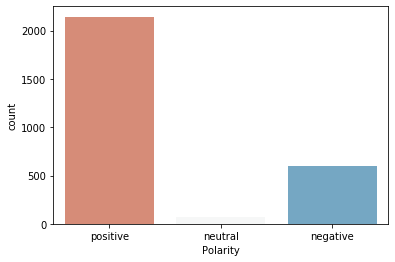

In [19]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
sns.countplot(x='polarity', order=["positive", "neutral", "negative"], data=absaClean, palette='RdBu')
plt.xlabel('Polarity')
plt.show()

In [20]:
absaClean.polarity.value_counts()

positive    2144
negative     594
neutral       71
Name: polarity, dtype: int64

### Aspect term extraction

Aspect term extraction using SpaCy

In [21]:
import en_core_web_sm
nlp = en_core_web_sm.load()

aspect_terms = []
for review in nlp.pipe(absaClean.processed_sentence):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
absaClean['aspect_terms'] = aspect_terms
absaClean.sample(10)

C:\Users\fx505\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sentence_id,processed_sentence,target,category,polarity,aspect_terms
720,1471273:2,impressed food,food,FOOD#QUALITY,negative,food
1238,552:0,chai latte heavenly,chai latte,DRINKS#QUALITY,positive,
800,1543345:2,get pepperoni yum family style salad,pepperoni,FOOD#QUALITY,positive,style
44,19:2,great price,NULL,RESTAURANT#PRICES,positive,price
179,76:1,10 dollar size small baby,NULL,FOOD#STYLE_OPTIONS,positive,size baby
623,273:1,good food friendly service,service,SERVICE#GENERAL,positive,service
711,1470334:1,es bagel either sty town midtown far best bage...,bagel,FOOD#QUALITY,positive,town
673,1451107:5,really large portion,portions,FOOD#STYLE_OPTIONS,positive,portion
809,1561259:2,hostess waitress incredibly rude everything co...,waitress,SERVICE#GENERAL,negative,waitress
1838,957145:3,also amazed new addition past year new jazz ba...,Thin Crust Pizzas,FOOD#QUALITY,positive,addition year jazz garden


In [22]:
# Put all the aspect terms found into a list
# aspect_list = absaClean.aspect_terms.tolist()
absaClean = absaClean.dropna()
aspect_list = absaClean.aspect_terms.tolist()
#Tokenize each aspect
aspect_tokenized = [string.split() for string in aspect_list]
flatten = [item for sublist in aspect_tokenized for item in sublist]
# Filter out the empty strings
aspect_list_nonull = [string for string in flatten if string != '']
aspect_list_nonull
# Remove duplicated aspect terms
aspect_list_nodup = list(set(aspect_list_nonull))
aspect_list_final = [i for i in aspect_list_nodup if len(i) > 1]
print(aspect_list_nodup)


['bargain', 'yums', 'pleasant', 'com', 'taste', 'wood', 'chain', 'finish', 'bite', 'regret', 'pizzaria', 'pork', 'guest', 'beer', 'tortilla', 'uws', 'company', 'stink', 'water', 'towner', 'croissant', 'coffee', 'atmosphere', 'country', 'overdone', 'ppp', 'tupperware', 'royalty', 'skin', 'duck', 'side', 'boy', 'sugar', 'rule', 'heart', 'alternative', 'dinner', 'write', 'story', 'choice', 'deal', 'beat', 'scone', 'day', 'seating', 'microbrewery', 'money', 'noir', 'certificate', 'nacho', 'sit', 'portion', 'chow', 'cozy', 'course', 'brother', 'quantity', 'scene', 'lobster', 'prick', 'piece', 'dispenser', 'occassion', 'mind', 'togethers', 'owner', 'attention', 'sweat', 'yirga', 'football', 'sea', 'point', 'prompt', 'dish', 'tiramisu', 'background', 'dal', 'entryway', 'tortelini', 'star', 'waffle', 'interior', 'preparation', 'shrimp', 'homeybali', 'plate', 'neighborhood', 'name', 'tunny', 'flores', 'character', 'reading', 'space', 'pesto', 'average', 'boyfriend', 'popcorn', 'cause', 'toilet'

### Helper function: get_all_phrases_containing_tar_wrd

Given a review, this function returns all the neighborhood terms containing the target word in a text/passage.

In [23]:
import nltk
def get_all_phrases_containing_tar_wrd(target_word, tar_passage, left_margin = 5, right_margin = 5):
    """
        Function to get all the pharses that contain the target word in a text/passage tar_passage.
        Workaround to save the output given by nltk Concordance function
        
        str target_word --> aspect to be searched for
        str tar_passage  --> sentence extracted from a customer review
        int left_margin int right_margin --> left_margin and right_margin allocate the number of words/punctuation before and after target word
        Left margin will take note of the beginning of the text
    """
     
    ## Create list of tokens using nltk function
    tokens = nltk.word_tokenize(tar_passage)
    tokens = [x for x in tokens if len(x)>2] 
    ## Create the text of tokens
    text = nltk.Text(tokens)
 
    ## Collect all the index or offset position of the target word
    c = nltk.ConcordanceIndex(text.tokens, key = lambda s: s.lower())
 
    ## Collect the range of the words that is within the target word by using text.tokens[start;end].
    ## The map function is use so that when the offset position - the target range < 0, it will be default to zero
    
    concordance_txt = ([text.tokens[  list(map(lambda x: x-5 if (x-left_margin)>0 else 0,[offset]))[0]:offset+right_margin] for offset in c.offsets(target_word)])

    ## join the sentences for each of the target phrase and return it
    return [''.join([x+' ' for x in con_sub]) for con_sub in concordance_txt]

##### Breaking down the sentences into phrases containing relevant aspects.
Below is the main body of the aspect extraction code. The pseudocode is as follows:

For each review in the list of reviews: <br>
    &nbsp;&nbsp;Break down the review in sentences. <br>
    &nbsp;&nbsp;for each sentence in the review: <br>
        &nbsp;&nbsp;&nbsp;&nbsp;Break down the sentence into phrases - a phrase here is a +/- 5 words neighborhood of the aspect. <br>
        &nbsp;&nbsp;&nbsp;&nbsp;For each phrase containing a relevant aspect: <br>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Append data for a new row entry for the dataframe. <br>

In [24]:
from nltk import sent_tokenize
#nltk.download('punkt')

# Select the aspects we believe are relevant 
relevant_aspects = aspect_list_final

reviews = absaClean.processed_sentence.tolist()
category = absaClean['category'].tolist()
polarity = absaClean['polarity'].tolist()

## Make lists for each of the columns that we will have in our new dataframe
phrases = []
aspects = []
review_num = []
categories = []
polarities = []
counter = 0

# Loop through all the reviews
for review in reviews:
    try:
        # Break the reviews in sentences and loop through them
        for sentence in sent_tokenize(review):
            for  important_word in relevant_aspects:
                # Get all the phrases containing one of the topic names
                # Create append list of phrases, aspects, ratings etc to create a DF
                phrases_in_sentence = get_all_phrases_containing_tar_wrd(important_word, sentence, left_margin = 5, right_margin = 5) 
                for phrase in phrases_in_sentence:
                    categories.append(category[counter])
                    polarities.append(polarity[counter])
                    aspect = 'other'
                    for imp_word in relevant_aspects:
                        if imp_word in phrase.lower():
                            aspect = imp_word
                    aspects.append(aspect)
                    phrases.append(phrase)
                    review_num.append(counter)
    except:
        pass
    counter = counter + 1

print('Extracted ' + str(len(phrases)) + ' phrases from the reviews')

# Create the phrases dataframe
phrasesDF = pd.DataFrame()
phrasesDF['review_id'] = review_num
phrasesDF['phrase'] = phrases
phrasesDF['category'] = categories
phrasesDF['aspect_term'] = aspects
phrasesDF['polarity'] = polarities
pd.set_option('display.max_rows', phrasesDF.shape[0]+1)
finalPhrasesDF = phrasesDF.drop_duplicates(subset=['phrase', 'category', 'aspect_term'], keep="first")
finalPhrasesDF2 = finalPhrasesDF.drop_duplicates(subset=['review_id', 'category', 'aspect_term'], keep="first")
finalPhrasesDF2

Extracted 8232 phrases from the reviews


,review_id,phrase,category,aspect_term,polarity
0,0,judging previous post used good place longer,RESTAURANT#GENERAL,good,negative
3,1,four arrived noon place empty staff acted like,SERVICE#GENERAL,staff,negative
6,2,complimentary noodle ignored repeated request ...,SERVICE#GENERAL,request,negative
12,3,food lousy sweet salty portion tiny,FOOD#QUALITY,salt,negative
14,4,food lousy sweet salty portion tiny,FOOD#STYLE_OPTIONS,salt,negative
16,5,complained small tip,SERVICE#GENERAL,tip,negative
17,6,avoid place,RESTAURANT#GENERAL,avoid,negative
19,7,eaten saul many time food always consistently ...,FOOD#QUALITY,eat,positive
21,7,time food always consistently outrageously good,FOOD#QUALITY,good,positive
22,8,saul best restaurant smith street brooklyn,RESTAURANT#GENERAL,brooklyn,positive


In [25]:
#finalPhrasesDF.to_csv(r'C:\Users\fx505\Desktop\Bryan\UniWork\Year3Sem1(2020)\FIT3162(Project-2)\Final Code\Data Cleaning (Bryan Wong)\ABSACOMBINED.csv', index = False)

### Additional Analysis
### The code below is to find co-occurences between the aspect term and the category.

In [26]:
fun = {'phrase' : 'count'}

phrasesFreqDF = finalPhrasesDF2.groupby(['aspect_term','category']).agg(fun).rename(columns={'phrase':'frequency'})
phrasesFreqDF = phrasesFreqDF.reset_index()  # turn 'class' groups into column values
phrasesFreqDF

,aspect_term,category,frequency
0,addition,FOOD#PRICES,1
1,addition,FOOD#STYLE_OPTIONS,1
2,alright,RESTAURANT#PRICES,1
3,ambiance,AMBIENCE#GENERAL,2
4,ambience,AMBIENCE#GENERAL,2
5,ambience,FOOD#QUALITY,2
6,ambience,LOCATION#GENERAL,1
7,appetizer,FOOD#QUALITY,8
8,appetizer,FOOD#STYLE_OPTIONS,2
9,appetizer,SERVICE#GENERAL,1


In [27]:
phrasesFreqDF['bigram'] = list(zip(phrasesFreqDF.aspect_term, phrasesFreqDF.category))
phrasesFreqDF

,aspect_term,category,frequency,bigram
0,addition,FOOD#PRICES,1,"(addition, FOOD#PRICES)"
1,addition,FOOD#STYLE_OPTIONS,1,"(addition, FOOD#STYLE_OPTIONS)"
2,alright,RESTAURANT#PRICES,1,"(alright, RESTAURANT#PRICES)"
3,ambiance,AMBIENCE#GENERAL,2,"(ambiance, AMBIENCE#GENERAL)"
4,ambience,AMBIENCE#GENERAL,2,"(ambience, AMBIENCE#GENERAL)"
5,ambience,FOOD#QUALITY,2,"(ambience, FOOD#QUALITY)"
6,ambience,LOCATION#GENERAL,1,"(ambience, LOCATION#GENERAL)"
7,appetizer,FOOD#QUALITY,8,"(appetizer, FOOD#QUALITY)"
8,appetizer,FOOD#STYLE_OPTIONS,2,"(appetizer, FOOD#STYLE_OPTIONS)"
9,appetizer,SERVICE#GENERAL,1,"(appetizer, SERVICE#GENERAL)"


In [28]:
bigramDF = phrasesFreqDF[['bigram', 'frequency']].sort_values(by=['frequency'], ascending=False)
bigramDF = bigramDF.head(50)
bigramDF

,bigram,frequency
259,"(eat, FOOD#QUALITY)",85
761,"(ser, SERVICE#GENERAL)",81
265,"(eat, SERVICE#GENERAL)",51
387,"(good, FOOD#QUALITY)",45
808,"(staff, SERVICE#GENERAL)",40
756,"(ser, FOOD#QUALITY)",38
929,"(try, FOOD#QUALITY)",36
347,"(food, FOOD#QUALITY)",34
262,"(eat, RESTAURANT#GENERAL)",33
129,"(cheese, FOOD#QUALITY)",33


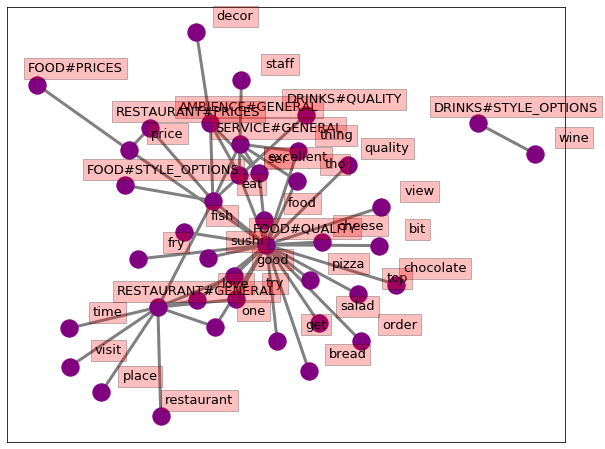

In [29]:
import networkx as nx

# Create dictionary of bigrams and their counts
d = bigramDF.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()